In [1]:
import os
import glob
import numpy as np

from matplotlib import pyplot as plt

import scipy.io.wavfile as wav
from scipy.fftpack import fft
from scipy import signal

import librosa
import IPython.display as ipd

import matplotlib.pyplot as plt
from librosa.display import specshow, waveplot

from tensorflow import set_random_seed

np.random.seed(42)
set_random_seed(42)

%matplotlib inline

C:\python36\envs\machine_learning\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Exploration

## Length audio

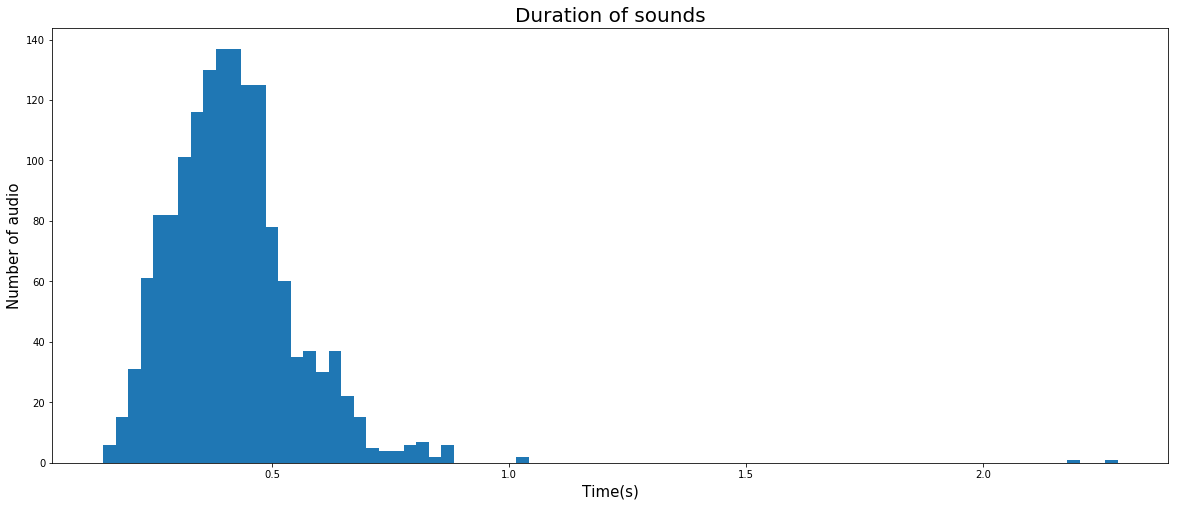

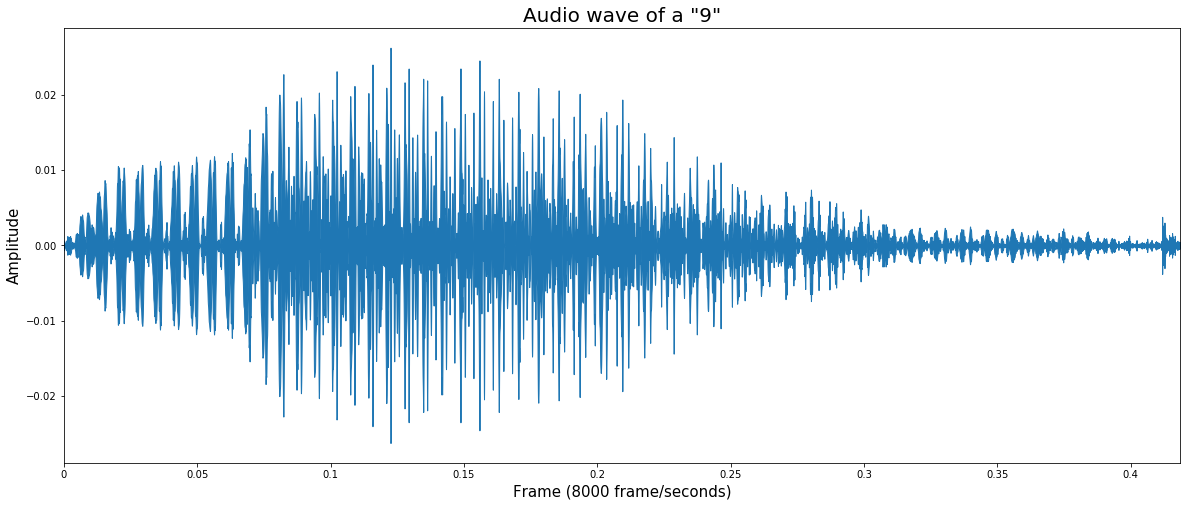

In [2]:
cnt = []
for i, audio_path in enumerate(glob.glob("free-spoken-digit-dataset-master/recordings/*.wav")):
    filename = os.path.basename(audio_path)[:-4]

    x, sr = librosa.load(audio_path)
    
    x = librosa.to_mono(x)
    
    cnt.append(len(x) / sr)

plt.figure(figsize=(20,8))
plt.hist(cnt, bins=81)
plt.title("Duration of sounds", fontsize=20)
plt.xlabel("Time(s)", fontsize=15)
plt.ylabel("Number of audio", fontsize=15)
plt.show()

plt.figure(figsize=(20,8))
# plt.plot(samples) 
librosa.display.waveplot(x, sr=sr)
plt.title("Audio wave of a \"9\"", fontsize=20)
plt.xlabel("Frame (8000 frame/seconds)", fontsize=15)
plt.ylabel("Amplitude", fontsize=15)
plt.show()       

# Scipy vs Librosa

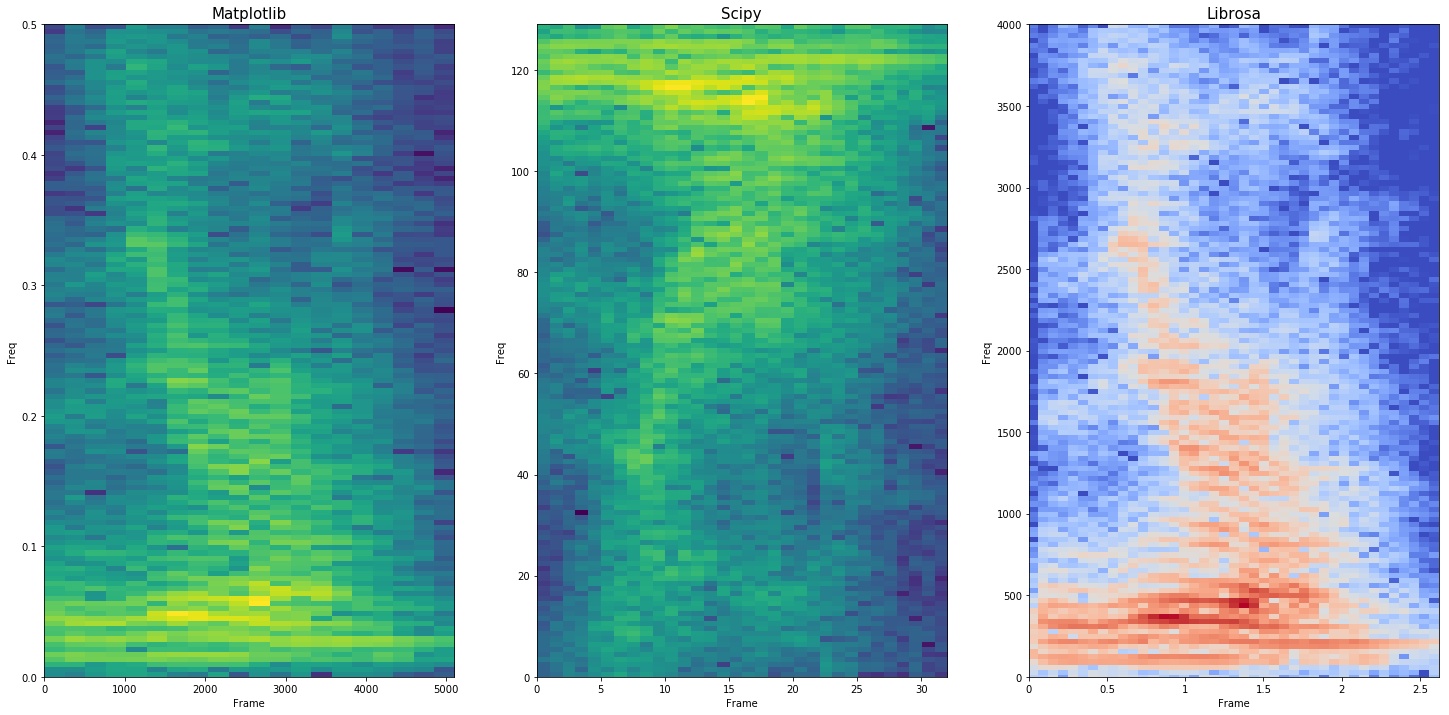

In [3]:
baseline_audio = "free-spoken-digit-dataset-master/recordings/0_jackson_0.wav"

sample_rate, samples = wav.read(baseline_audio)

if len(samples.shape) > 1:
    samples = samples[:,0]

plt.figure(figsize=(25,12))
        
# From matplotlib
plt.subplot(1, 3, 1)
PxN, freqsN, binsN, imN = plt.specgram(samples, 
                                       NFFT = 256, 
                                       Fs=1, 
                                       Fc=0, 
                                       #detrend=mlab.detrend_none,
                                       window = signal.tukey(256),
                                       pad_to = None,
                                       noverlap = 1
                                      )
plt.ylabel("Freq")
plt.xlabel("Frame")
plt.title("Matplotlib", fontsize=15)
# print(freqsN)
# print(binsN)
# print(PxN.shape)

# scipy
frequencies, times, spectogram = signal.spectrogram(samples, 
                                                    fs=1, 
                                                    nfft=256, 
                                                    window=('tukey', 0.25),
                                                    nperseg = sample_rate//50,
                                                    noverlap = 1,
                                                    #detrend 
                                                    scaling = "density",
                                                    mode = "magnitude"
                                                   )
# print(frequencies)
# print(times)
# print(spectogram.shape)

plt.subplot(1, 3, 2)
plt.imshow(np.log(spectogram), extent=[0,spectogram.shape[1],0,spectogram.shape[0]], aspect='auto')
plt.ylabel("Freq")
plt.xlabel("Frame")
plt.title("Scipy", fontsize=15)

# Librosa
y, sr = librosa.load(baseline_audio, sr=None)
y = librosa.to_mono(y)

# np.abs(D[f, t]) is the magnitude of frequency bin f at frame t
# np.angle(D[f, t]) is the phase of frequency bin f at frame t
D = librosa.stft(y, 
                 n_fft = 256, 
                 hop_length = 128, # hop_length = 20 ms
                 win_length = 256,
                 window = signal.tukey(256),
                )  
# print(D.shape)

plt.subplot(1, 3, 3)
# plt.imshow(np.log(np.abs(D)), extent=[0, D.shape[1], 0, D.shape[0]], aspect='auto')
Xdb = librosa.amplitude_to_db(abs(D))
librosa.display.specshow(Xdb, sr=sample_rate, x_axis='time', y_axis='hz')
plt.ylabel("Freq")
plt.xlabel("Frame")
plt.title("Librosa", fontsize=15)

plt.show()

#######################################

# S = np.abs(D)
# comps, acts = librosa.decompose.decompose(S, n_components=8)
        
# plt.figure(figsize=(20,6))

# plt.subplot(1, 2, 1)
# librosa.display.specshow(comps, y_axis='log', x_axis='time')
# plt.colorbar(format='%+2.0f dB')

# plt.subplot(1, 2, 2)
# librosa.display.specshow(acts, x_axis='time')
# plt.colorbar(format='%+2.0f dB')

# plt.show()

# #######################################

# H, P = librosa.decompose.hpss(D, margin=3.0)
# R = D - (H + P)
        
# plt.figure(figsize=(20,20))

# plt.subplot(3, 1, 1)
# specshow(librosa.amplitude_to_db(D,ref=np.max),y_axis='log', x_axis='time')
# plt.colorbar(format='%+2.0f dB')
# plt.title('Full power spectrogram')

# plt.subplot(3, 1, 2)
# specshow(librosa.amplitude_to_db(H,ref=np.max),y_axis='log')
# plt.colorbar(format='%+2.0f dB')
# plt.title('Harmonic power spectrogram')

# plt.subplot(3, 1, 3)
# specshow(librosa.amplitude_to_db(P,ref=np.max),y_axis='log')
# plt.colorbar(format='%+2.0f dB')
# plt.title('Percussive power spectrogram')

# plt.tight_layout()
# plt.show()

####################################

We can play more with Scipy on differents values, this library seems more suitable for the future.

# Decomposition with Scipy

From the duration we saw previously, we have only few sounds longer than 1s. Let's computer the FFT on every sounds but after extended them to 1s (of cut them at 1s).

In [4]:
spectrogram_dir = "datas/spectrograms"

In [5]:
for i, audio_path in enumerate(glob.glob("free-spoken-digit-dataset-master/recordings/*.wav")):
    filename = os.path.basename(audio_path)[:-4]

    y, sr = librosa.load(audio_path, sr=None)
    y = librosa.to_mono(y)
    
    if sr != 8000:
        y = librosa.resample(y, sr, 8000)
    
    new_sound = np.zeros((sr, ))
    l = len(y)
    if l > sr:
        new_sound = y[:8000]
    else:
        new_sound[:l] = y
            
    frequencies, times, spectogram = signal.spectrogram(new_sound,                                                     
                                                        fs=1, 
                                                        nfft=256, 
                                                        window=('tukey', 0.25),
                                                        nperseg = sr//40,
                                                        noverlap = 2,
                                                        #detrend 
                                                        scaling = "density",
                                                        mode = "magnitude")
    if i == 0:
        np.save(os.path.join(spectrogram_dir,"meta", "frequency.npy"), frequencies)
        np.save(os.path.join(spectrogram_dir,"meta", "times.npy"), times)
    
    np.save(os.path.join(spectrogram_dir, filename + ".npy"), spectogram)

In [6]:
X = []
label = []
user = []
for i, matrix_path in enumerate(glob.glob(spectrogram_dir + "/*.npy")):
    filename = os.path.basename(matrix_path)[:-4]
    spectrogram = np.load(matrix_path)
    spectrogram = np.log10(spectrogram+1)
    parsed_filename = filename.split("_")
    label.append(int(parsed_filename[0]))
    user.append(parsed_filename[1])
    X.append(spectrogram.flatten().reshape(1,-1)[0])
    
y = np.array(label)
user = np.array(user)
X = np.array(X)
np.save("datas/scipy/y.npy", y)
np.save("datas/scipy/X.npy", X)
np.save("datas/scipy/user.npy", user)

In [7]:
y = np.load("datas/scipy/y.npy")
X = np.load("datas/scipy/X.npy")
user = np.load("datas/scipy/user.npy")

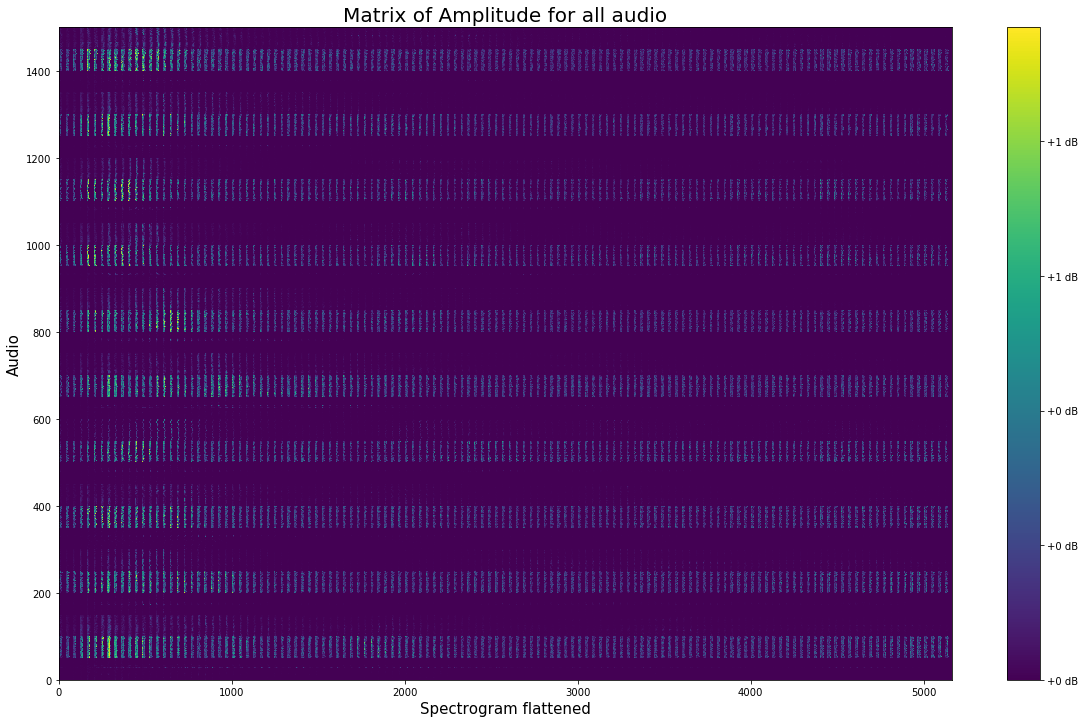

In [8]:
plt.figure(figsize = (20, 12))
plt.imshow(X, extent=[0, X.shape[1], 0, X.shape[0]], aspect='auto');
plt.colorbar(format='%+2.0f dB')
plt.title("Matrix of Amplitude for all audio", fontsize=20)
plt.xlabel("Spectrogram flattened", fontsize=15)
plt.ylabel("Audio", fontsize=15)
plt.show()

## correction volumes

We can see that ye have 10 "lines" brighter than the other one. This is related to the maginitude of frequences. Based on the dataset, we know that 10 people says the 10 digits 50 times. As a result the "thick" lines reprensent a digit said by someone. What we should do is balance the average of the audio to the same level.

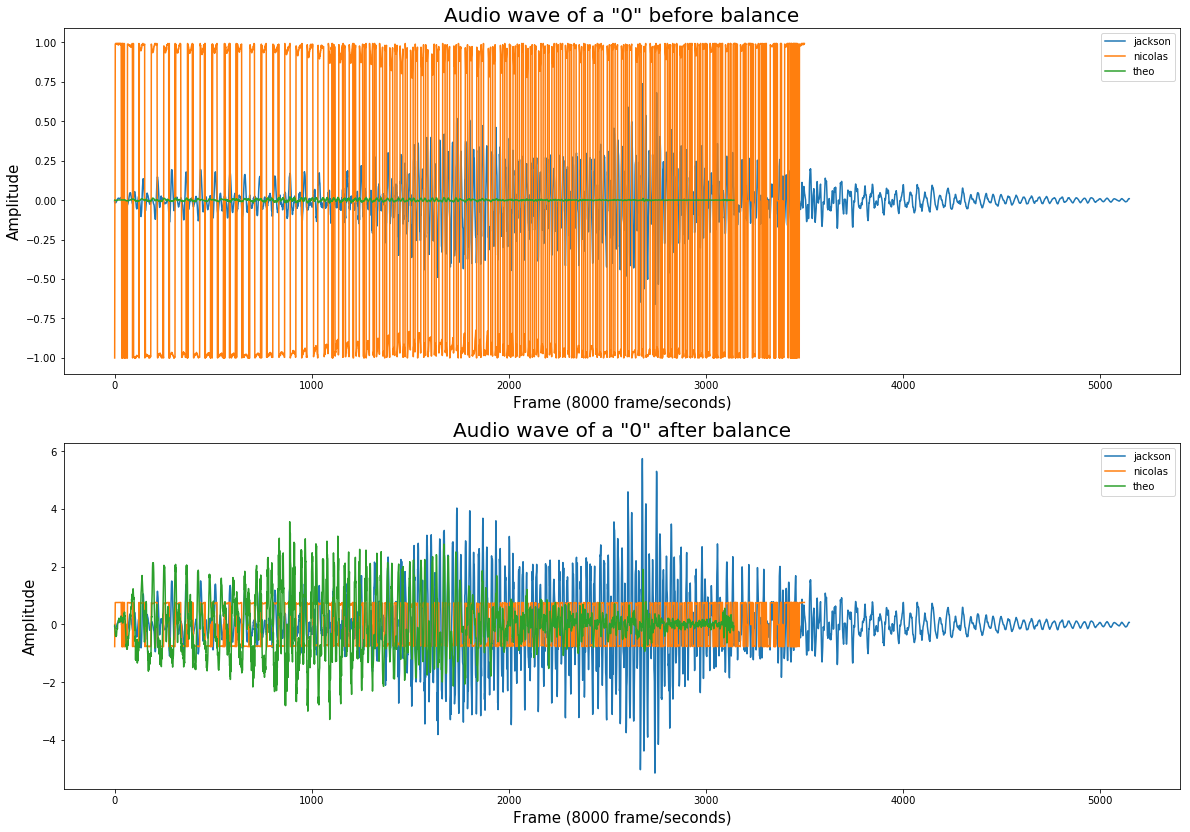

In [9]:
authors = ["jackson", "nicolas", "theo"]
plt.figure(figsize=(20,14))

for author in authors:
    audio_path = "free-spoken-digit-dataset-master/recordings/0_"+author+"_0.wav"
    
    y, sr = librosa.load(audio_path, sr=None)
    y = librosa.to_mono(y)
    
    if sr != 8000:
        y = librosa.resample(y, sr, 8000)
    
    avg_audio = np.abs(y).mean()
    y_2 = y *0.7/avg_audio
    
    plt.subplot(2, 1, 1)
    plt.plot(y, label=author) 
    plt.title("Audio wave of a \"0\" before balance", fontsize=20)
    plt.xlabel("Frame (8000 frame/seconds)", fontsize=15)
    plt.ylabel("Amplitude", fontsize=15)
    plt.legend()
    
    plt.subplot(2, 1, 2)
    plt.plot(y_2, label=author) 
    plt.title("Audio wave of a \"0\" after balance", fontsize=20)
    plt.xlabel("Frame (8000 frame/seconds)", fontsize=15)
    plt.ylabel("Amplitude", fontsize=15)
    plt.legend()
    
plt.show()   

In [10]:
spectrogram_dir_2 = "datas/spectrograms_new_volume"

In [11]:
for i, audio_path in enumerate(glob.glob("free-spoken-digit-dataset-master/recordings/*.wav")):
    filename = os.path.basename(audio_path)[:-4]

    y, sr = librosa.load(audio_path, sr=None)
    y = librosa.to_mono(y)
    
    if sr != 8000:
        y = librosa.resample(y, sr, 8000)
    
    new_sound = np.zeros((sr, ))
    l = len(y)
    if l > sr:
        new_sound = y[:8000]
    else:
        new_sound[:l] = y
        
    avg_audio = np.abs(new_sound).mean()
    new_sound = new_sound * 0.7 / avg_audio
            
    frequencies, times, spectogram = signal.spectrogram(new_sound,                                                     
                                                        fs=1, 
                                                        nfft=256, 
                                                        window=('tukey', 0.25),
                                                        nperseg = sr//40,
                                                        noverlap = 2,
                                                        #detrend 
                                                        scaling = "density",
                                                        mode = "magnitude"
                                                       )
    
    if i == 0:
        np.save(os.path.join(spectrogram_dir_2,"meta", "frequency.npy"), frequencies)
        np.save(os.path.join(spectrogram_dir_2,"meta", "times.npy"), times)
    
    np.save(os.path.join(spectrogram_dir_2, filename + ".npy"), spectogram)

In [12]:
X = []
label = []
user = []
for i, matrix_path in enumerate(glob.glob(spectrogram_dir_2 + "/*.npy")):
    filename = os.path.basename(matrix_path)[:-4]
    spectrogram = np.load(matrix_path)
    spectrogram = np.log10(spectrogram+1)
    parsed_filename = filename.split("_")
    label.append(int(parsed_filename[0]))
    user.append(parsed_filename[1])
    X.append(spectrogram.flatten().reshape(1,-1)[0])
    
y = np.array(label)
user = np.array(user)
X = np.array(X)
np.save("datas/scipy_new_volume/y.npy", y)
np.save("datas/scipy_new_volume/X.npy", X)
np.save("datas/scipy_new_volume/user.npy", user)

In [13]:
y = np.load("datas/scipy_new_volume/y.npy")
X = np.load("datas/scipy_new_volume/X.npy")
user = np.load("datas/scipy_new_volume/user.npy")

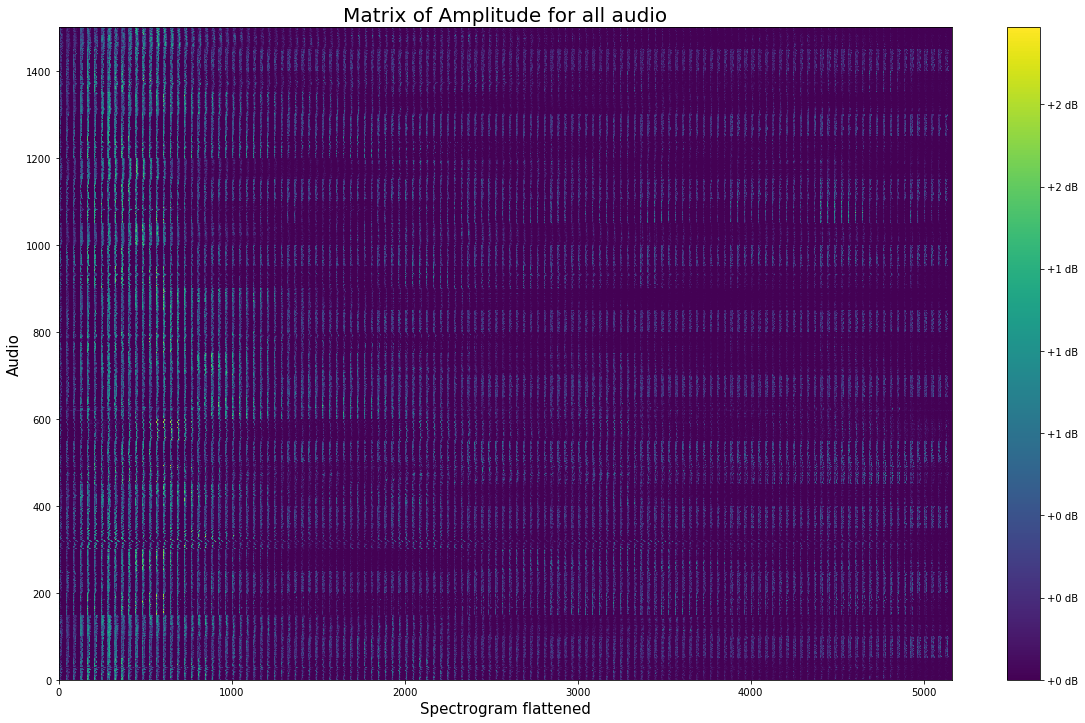

In [14]:
plt.figure(figsize = (20, 12))
plt.imshow(X, extent=[0, X.shape[1], 0, X.shape[0]], aspect='auto');
plt.colorbar(format='%+2.0f dB')
plt.title("Matrix of Amplitude for all audio", fontsize=20)
plt.xlabel("Spectrogram flattened", fontsize=15)
plt.ylabel("Audio", fontsize=15)
plt.show()

Now we have something more balanced. We can now try to reduced dimensions and see the outcome.

## Unsupervised Part

We have now a matrix of 1500 lines x 5000+ features. As we can see we have a lot of vertical lines with low variance. The first thing we can do is to try dimensionnality reduction using PCA. But first, we hqve to scale our data.

In [15]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

In [16]:
from sklearn.decomposition import PCA

my_model = PCA(n_components=0.998)
X_reduced = my_model.fit_transform(X_scaled)

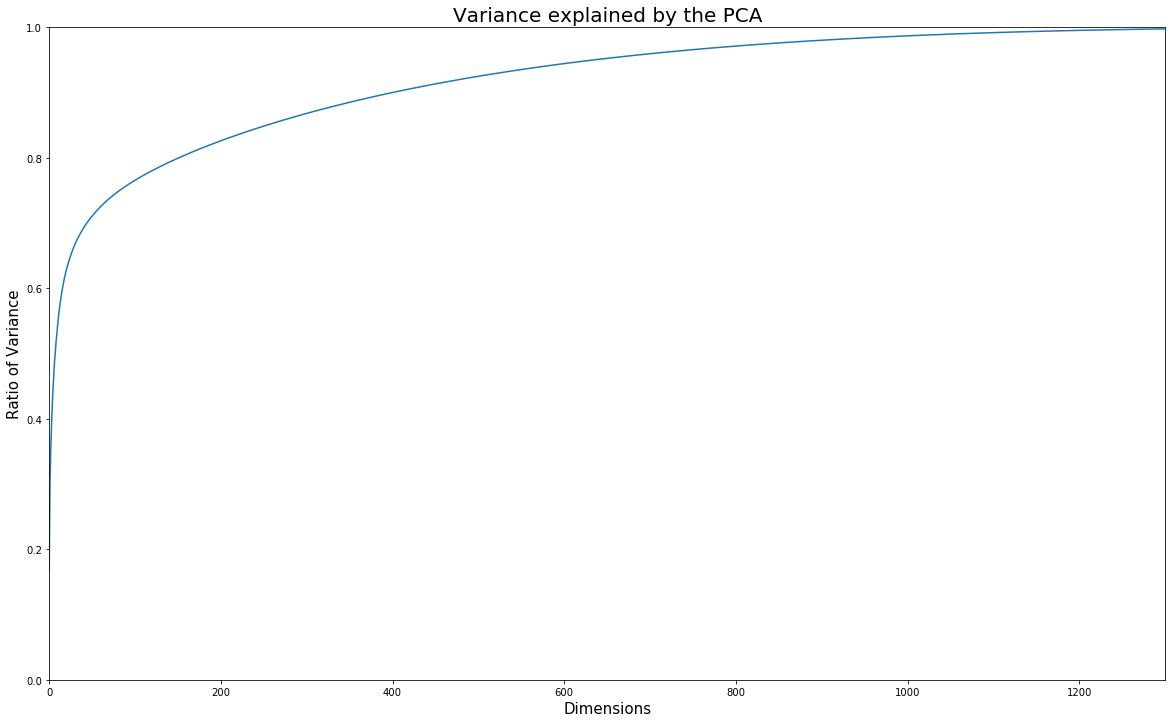

In [17]:
plt.figure(figsize = (20, 12))
plt.plot(my_model.explained_variance_ratio_.cumsum())
plt.title("Variance explained by the PCA", fontsize=20)
plt.xlabel("Dimensions", fontsize=15)
plt.ylabel("Ratio of Variance", fontsize=15)
plt.xlim(0, 1300)
plt.ylim(0, 1, format)
plt.show()

By keeping 99.8%  of the variance, we can still divide dimensions by 4. This is a wery good improvements. Now let's try to visualize it using TSNE. A Parameter grid will help to find the best set of parameters in order to reduce the KL-Divergence and having a good representation of the data.

In [18]:
from sklearn.manifold import TSNE
from sklearn.model_selection import ParameterGrid

In [19]:
param_grid = {'perplexity': [10, 30, 50, 100, 200], 'learning_rate': [100, 250, 500, 1000]}

for param in ParameterGrid(param_grid):
    tsne = TSNE(n_components=2, random_state=42, **param)
    X_embedded = tsne.fit_transform(X_reduced)
    print(param, tsne.kl_divergence_)

{'learning_rate': 100, 'perplexity': 10} 0.5845159888267517
{'learning_rate': 100, 'perplexity': 30} 0.48261889815330505
{'learning_rate': 100, 'perplexity': 50} 0.4449061155319214
{'learning_rate': 100, 'perplexity': 100} 0.3779586851596832
{'learning_rate': 100, 'perplexity': 200} 0.3249979019165039
{'learning_rate': 250, 'perplexity': 10} 0.584872305393219
{'learning_rate': 250, 'perplexity': 30} 0.4770835340023041
{'learning_rate': 250, 'perplexity': 50} 0.4400227665901184
{'learning_rate': 250, 'perplexity': 100} 0.3771384060382843
{'learning_rate': 250, 'perplexity': 200} 0.3023865520954132
{'learning_rate': 500, 'perplexity': 10} 0.5713032484054565
{'learning_rate': 500, 'perplexity': 30} 0.4764673113822937
{'learning_rate': 500, 'perplexity': 50} 0.4410386383533478
{'learning_rate': 500, 'perplexity': 100} 0.3757029175758362
{'learning_rate': 500, 'perplexity': 200} 0.3289583623409271
{'learning_rate': 1000, 'perplexity': 10} 0.587609052658081
{'learning_rate': 1000, 'perplexit

In [21]:
optim = {'learning_rate': 250, 'perplexity': 200}
tsne = TSNE(n_components=2, random_state=42, **optim)
X_embedded = tsne.fit_transform(X_reduced)

In [22]:
print(tsne.kl_divergence_)

0.3023865520954132


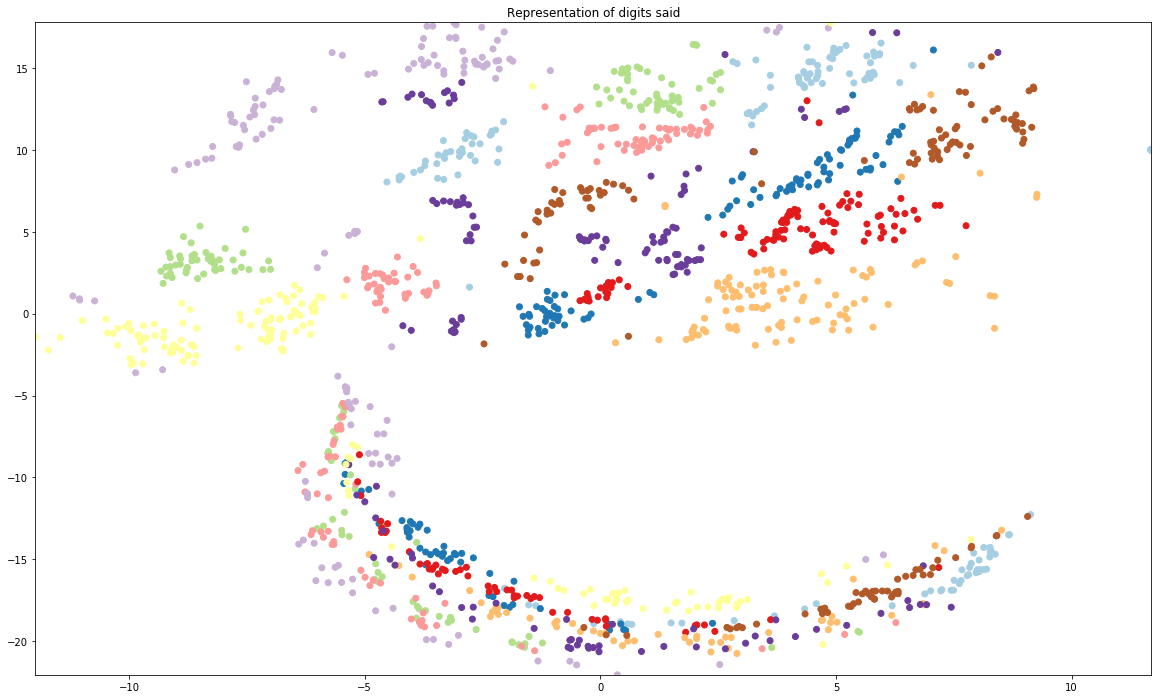

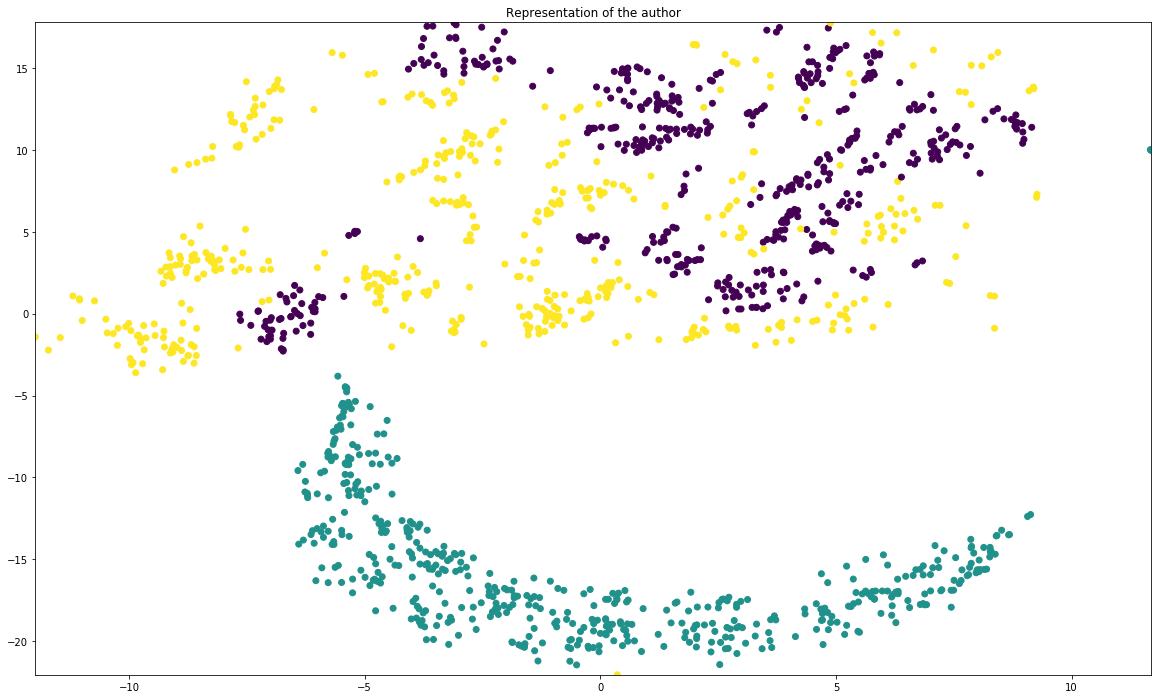

In [23]:
mapping= {'jackson': 1 , 'nicolas': 2 , 'theo': 3 }
m = [mapping[x] for x in user]

x_min = X_embedded[:, 0].min()
x_max = X_embedded[:, 0].max()
y_min = X_embedded[:, 1].min()
y_max = X_embedded[:, 1].max()

plt.figure(figsize=(20,12))
plt.scatter(X_embedded[:, 0], 
            X_embedded[:, 1], 
            c=y,
            cmap="Paired"
           )
    
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.title("Representation of digits said")
plt.show()

plt.figure(figsize=(20,12))
plt.scatter(X_embedded[:, 0], 
            X_embedded[:, 1], 
            c=m
           )
    
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.title("Representation of the author")
plt.show()

We can see that TSNE succeed to group similar audio related to the same digit. Based on the author, we can see different capacity of separating data but globally, the split is correct. 2 voice are similar and the digit saif by both is sometime very close. Now, let's try 2 classification models

# Supervised Learning

## Model 1 : Classical ANN

First, we can try the learning based on the X matrix but after dimensionnaly reduction.

In [24]:
y = np.load("datas/scipy_new_volume/y.npy")
X = np.load("datas/scipy_new_volume/X.npy")
user = np.load("datas/scipy_new_volume/user.npy")

In [25]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

In [26]:
from sklearn.decomposition import PCA

my_model = PCA(n_components=0.9)
X_reduced = my_model.fit_transform(X_scaled)

If we want to keep 90 of the variance we are now at 400 dimensions, this should be fine for a simple ANN.

In [27]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelBinarizer

enc = LabelBinarizer()
y_enc = enc.fit_transform(y.reshape(-1, 1))

X_train, X_test, y_train, y_test = train_test_split(X_reduced, y_enc, test_size=0.20, random_state=42)

In [28]:
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization, Dropout

model = Sequential()
model.add(Dense(100, input_dim=X_train.shape[1], activation='relu'))
# model.add(BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001))
model.add(Dropout(0.4))
model.add(Dense(30, activation='relu'))
# model.add(BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001))
model.add(Dropout(0.2))
model.add(Dense(10, activation='softmax'))

model.summary()

model.compile(loss='categorical_crossentropy', optimizer='Nadam', metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               40100     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 30)                3030      
_________________________________________________________________
dropout_2 (Dropout)          (None, 30)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                310       
Total params: 43,440
Trainable params: 43,440
Non-trainable params: 0
_________________________________________________________________


Using TensorFlow backend.


In [29]:
history_ann = model.fit(X_train, y_train, 
                          epochs=50, 
                          batch_size=100, 
                          verbose=2, 
                          validation_data=(X_test, y_test))

Train on 1200 samples, validate on 300 samples
Epoch 1/50
 - 2s - loss: 2.2277 - acc: 0.2025 - val_loss: 1.9713 - val_acc: 0.4867
Epoch 2/50
 - 0s - loss: 1.8667 - acc: 0.4008 - val_loss: 1.6203 - val_acc: 0.6667
Epoch 3/50
 - 0s - loss: 1.4784 - acc: 0.5842 - val_loss: 1.2492 - val_acc: 0.7433
Epoch 4/50
 - 0s - loss: 1.1492 - acc: 0.6667 - val_loss: 0.9364 - val_acc: 0.8200
Epoch 5/50
 - 0s - loss: 0.8686 - acc: 0.7592 - val_loss: 0.6994 - val_acc: 0.8600
Epoch 6/50
 - 0s - loss: 0.6530 - acc: 0.8317 - val_loss: 0.5458 - val_acc: 0.8933
Epoch 7/50
 - 0s - loss: 0.5002 - acc: 0.8717 - val_loss: 0.4527 - val_acc: 0.9067
Epoch 8/50
 - 0s - loss: 0.3845 - acc: 0.9083 - val_loss: 0.3776 - val_acc: 0.9233
Epoch 9/50
 - 0s - loss: 0.3148 - acc: 0.9108 - val_loss: 0.3208 - val_acc: 0.9300
Epoch 10/50
 - 0s - loss: 0.2427 - acc: 0.9400 - val_loss: 0.2933 - val_acc: 0.9300
Epoch 11/50
 - 0s - loss: 0.2153 - acc: 0.9492 - val_loss: 0.2673 - val_acc: 0.9400
Epoch 12/50
 - 0s - loss: 0.1959 - acc

With this model, we have to play with Dropout and size of layers to avoid overfitting. A very simple one reach 100 % success in training set in 4 epochs but test set remains blocked at around 89.6%. With dropout, it never reach 100 in train set and we can reach 93 % in test. Nevertheless, this model doesn't exploit the "feeling" of the music. To do so, we need to use Convolutionnal Neural Network to convert our spectrogram to semantic parts of music. On it, we can after classify it.

## Model 2 : Convolutionnal Neural Networks

In [30]:
y = np.load("datas/scipy_new_volume/y.npy")
X = np.load("datas/scipy_new_volume/X.npy")
user = np.load("datas/scipy_new_volume/user.npy")

In [31]:
X = X.reshape(1500, 129, -1, 1)

In [32]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

enc = LabelBinarizer()
y_enc = enc.fit_transform(y.reshape(-1, 1))

X_train_2, X_test_2, y_train, y_test = train_test_split(X, y_enc, test_size=0.20, random_state=42)

In [33]:
from keras.models import Sequential
from keras.layers import Dense, MaxPooling2D, Conv2D, Flatten, Dropout

model2 = Sequential()
model2.add(Conv2D(32, kernel_size=(2, 2), 
                 strides=(1, 1),
                 activation='relu',
                 input_shape=(129, 40, 1)))
model2.add(MaxPooling2D(pool_size=(2, 1)))
model2.add(Conv2D(64, (3, 3), activation='relu'))
model2.add(MaxPooling2D(pool_size=(2, 1)))
model2.add(Conv2D(64, (3, 3), activation='relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(Conv2D(128, (3, 3), activation='relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(Conv2D(128, (3, 3), activation='relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(Flatten())
# model.add(Dense(30, activation='relu'))
# model.add(Dense(10, activation='softmax'))
model2.add(Dense(100, input_dim=X_train.shape[1], activation='relu'))
model2.add(Dropout(0.4))
model2.add(Dense(30, activation='relu'))
model2.add(Dropout(0.2))
model2.add(Dense(10, activation='softmax'))

model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 128, 39, 32)       160       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 39, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 62, 37, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 31, 37, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 29, 35, 64)        36928     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 17, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 12, 15, 128)       73856     
__________

In [34]:
model2.compile(loss='categorical_crossentropy', optimizer='Nadam', metrics=['accuracy'])

In [35]:
history_cnn = model2.fit(X_train_2, y_train, 
                      epochs=50, 
                      batch_size=100, 
                      verbose=2, 
                      validation_data=(X_test_2, y_test))

Train on 1200 samples, validate on 300 samples
Epoch 1/50
 - 2s - loss: 2.2964 - acc: 0.1075 - val_loss: 2.2797 - val_acc: 0.1633
Epoch 2/50
 - 1s - loss: 2.2113 - acc: 0.1592 - val_loss: 2.0669 - val_acc: 0.3167
Epoch 3/50
 - 1s - loss: 1.9655 - acc: 0.2950 - val_loss: 1.7737 - val_acc: 0.3867
Epoch 4/50
 - 1s - loss: 1.6391 - acc: 0.4075 - val_loss: 1.3250 - val_acc: 0.5000
Epoch 5/50
 - 1s - loss: 1.2203 - acc: 0.5792 - val_loss: 0.8222 - val_acc: 0.7533
Epoch 6/50
 - 1s - loss: 0.9259 - acc: 0.6858 - val_loss: 0.6709 - val_acc: 0.7600
Epoch 7/50
 - 1s - loss: 0.6660 - acc: 0.7750 - val_loss: 0.4003 - val_acc: 0.8500
Epoch 8/50
 - 1s - loss: 0.4380 - acc: 0.8375 - val_loss: 0.3248 - val_acc: 0.8667
Epoch 9/50
 - 1s - loss: 0.6860 - acc: 0.7783 - val_loss: 0.3066 - val_acc: 0.9067
Epoch 10/50
 - 1s - loss: 0.3586 - acc: 0.8817 - val_loss: 0.2317 - val_acc: 0.9233
Epoch 11/50
 - 1s - loss: 0.3068 - acc: 0.8942 - val_loss: 0.2082 - val_acc: 0.9433
Epoch 12/50
 - 1s - loss: 0.2602 - acc

That's clearly better. Now we have 97.5% of test success compare to 95% with the same classifier. The difference is in one side, we use result from PCA and now we extract musical features with CNNs. 

## Analysis

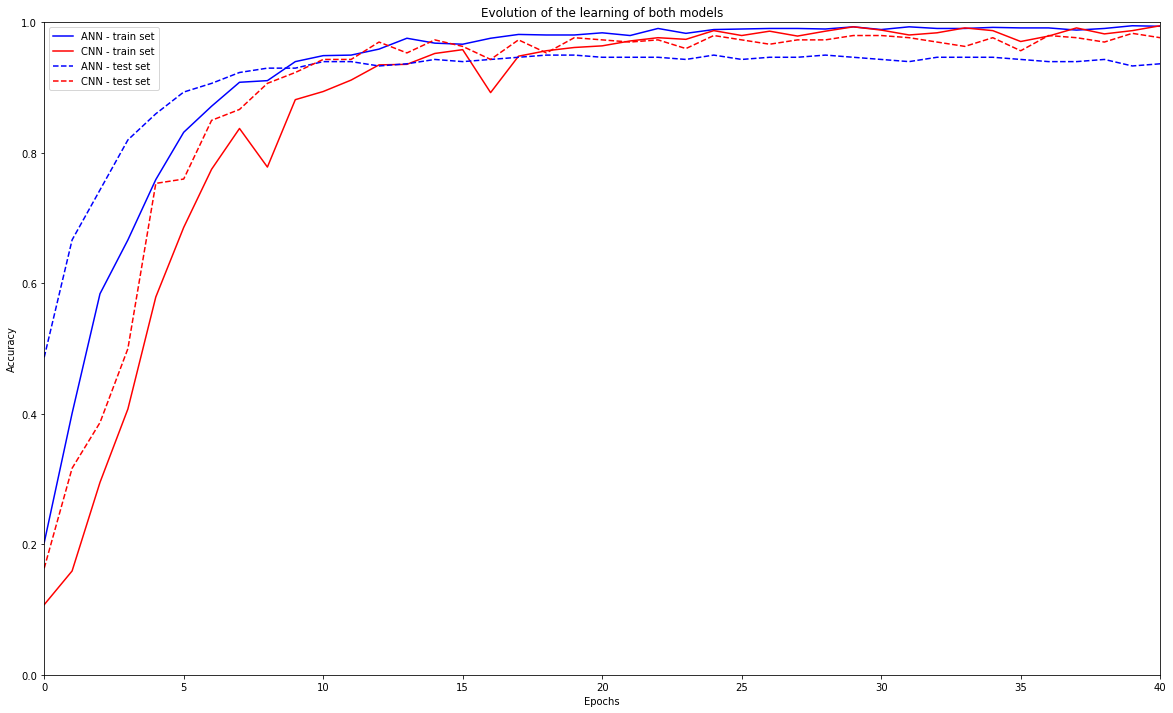

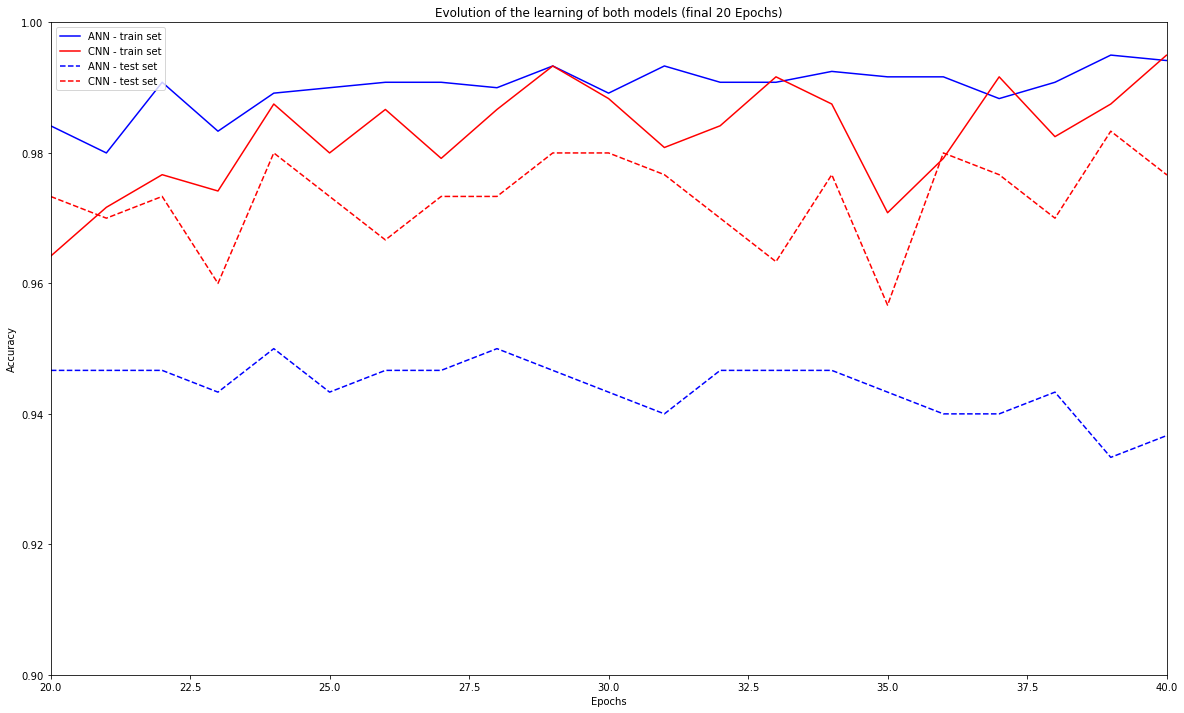

In [36]:
plt.figure(figsize=(20,12))
plt.plot(history_ann.history["acc"], c="b", label="ANN - train set")
plt.plot(history_cnn.history["acc"], c="r", label="CNN - train set")
plt.plot(history_ann.history["val_acc"], c="b", linestyle="--", label="ANN - test set")
plt.plot(history_cnn.history["val_acc"], c="r", linestyle="--", label="CNN - test set")
plt.legend()
plt.title("Evolution of the learning of both models")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.xlim(0, 40)
plt.ylim(0, 1)
plt.show()

plt.figure(figsize=(20,12))
plt.plot(history_ann.history["acc"], c="b", label="ANN - train set")
plt.plot(history_cnn.history["acc"], c="r", label="CNN - train set")
plt.plot(history_ann.history["val_acc"], c="b", linestyle="--", label="ANN - test set")
plt.plot(history_cnn.history["val_acc"], c="r", linestyle="--", label="CNN - test set")
plt.legend()
plt.title("Evolution of the learning of both models (final 20 Epochs)")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.xlim(20, 40)
plt.ylim(0.9, 1)
plt.show()

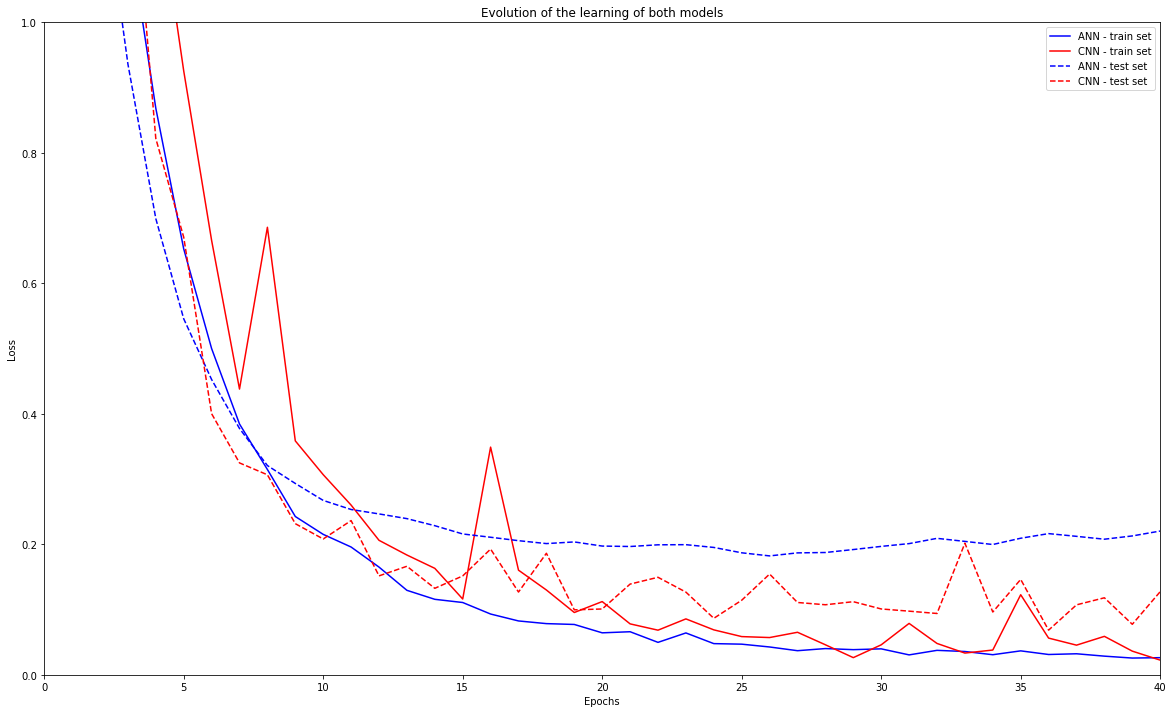

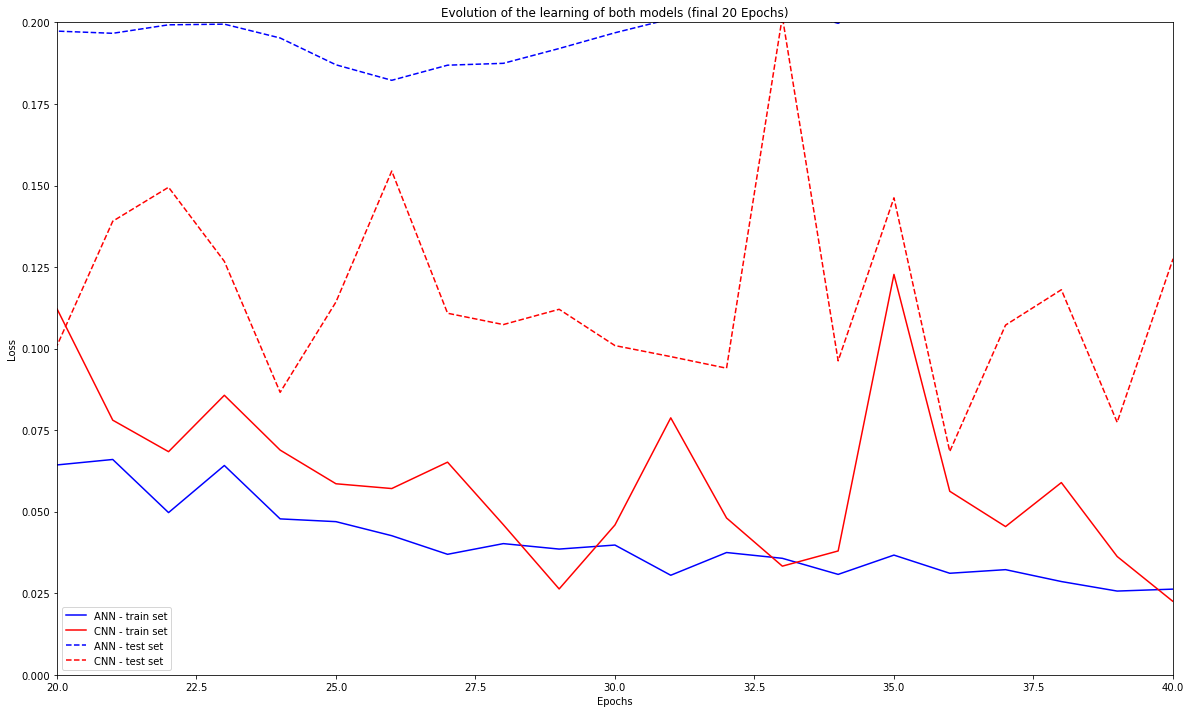

In [37]:
plt.figure(figsize=(20,12))
plt.plot(history_ann.history["loss"], c="b", label="ANN - train set")
plt.plot(history_cnn.history["loss"], c="r", label="CNN - train set")
plt.plot(history_ann.history["val_loss"], c="b", linestyle="--", label="ANN - test set")
plt.plot(history_cnn.history["val_loss"], c="r", linestyle="--", label="CNN - test set")
plt.legend()
plt.title("Evolution of the learning of both models")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.xlim(0, 40)
plt.ylim(0, 1)
plt.show()

plt.figure(figsize=(20,12))
plt.plot(history_ann.history["loss"], c="b", label="ANN - train set")
plt.plot(history_cnn.history["loss"], c="r", label="CNN - train set")
plt.plot(history_ann.history["val_loss"], c="b", linestyle="--", label="ANN - test set")
plt.plot(history_cnn.history["val_loss"], c="r", linestyle="--", label="CNN - test set")
plt.legend()
plt.title("Evolution of the learning of both models (final 20 Epochs)")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.xlim(20, 40)
plt.ylim(0, 0.2)
plt.show()

We can see that the CNN is not yet stable, maybe a learning scheduler would help but in any case it has around half of the error of the ANN. The trade-off is the computation time. For such small example it's around 5x slower but with millions of example of full duration music, this can be a problem. Nevertheless, his aptitude to learn feature is cleary more suitable. We also have to keep in mind that the ANN would a matrix with millions of features for a song. This cannot be used as easily. The PCA or other dimensionnaly reduction would be required. For CNN, there is just a need to reshape images in width to have the same length for all of them. Now let's take a look at the confusion matrix for both models.

In [38]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
#     plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [39]:
y_pred_1 = model.predict(X_test)
y_pred_2 = model2.predict(X_test_2)
y_pred_1 = enc.inverse_transform(y_pred_1)
y_pred_2 = enc.inverse_transform(y_pred_2)

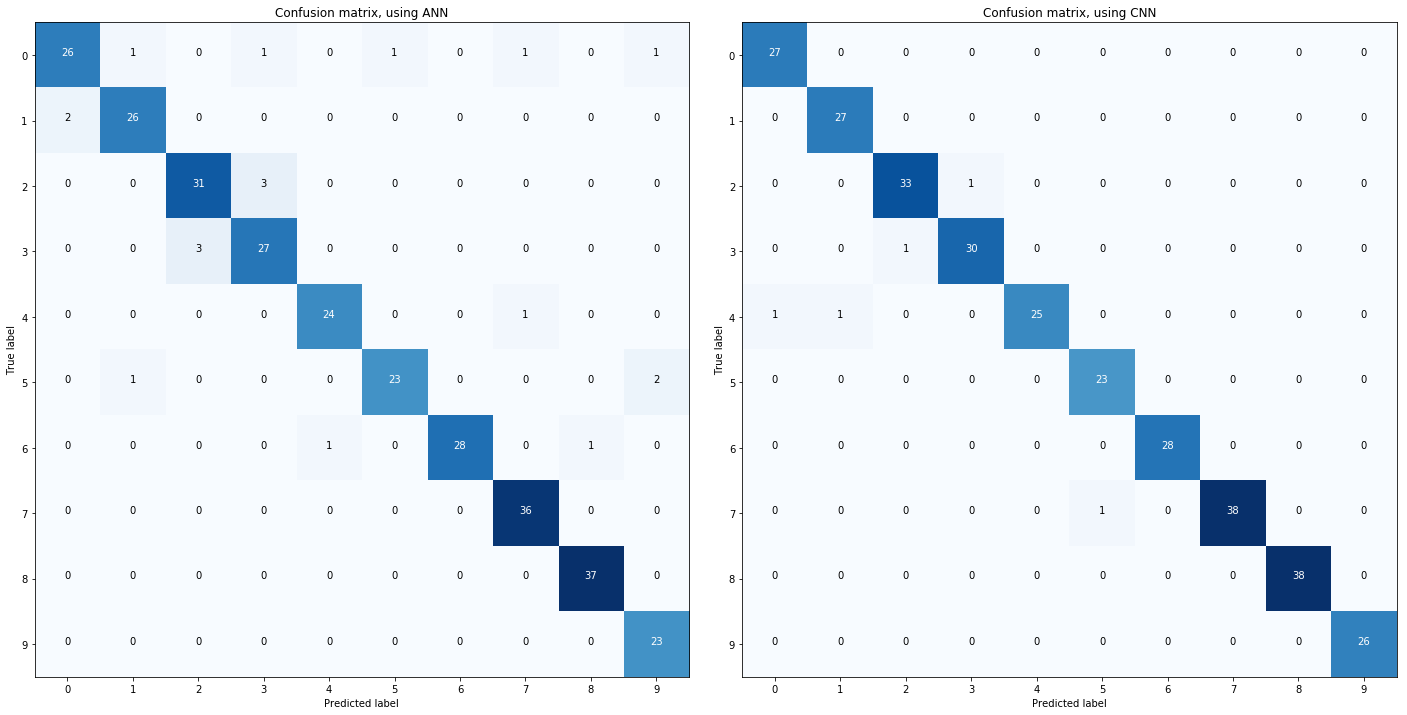

In [40]:
from sklearn.metrics import confusion_matrix
import itertools

cnf_matrix = confusion_matrix(y_pred_1, enc.inverse_transform(y_test), labels=enc.classes_ )
cnf_matrix_2 = confusion_matrix(y_pred_2, enc.inverse_transform(y_test), labels=enc.classes_ )

plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plot_confusion_matrix(cnf_matrix, classes=enc.classes_, title='Confusion matrix, using ANN')

plt.subplot(1, 2, 2)
plot_confusion_matrix(cnf_matrix_2, classes=enc.classes_, title='Confusion matrix, using CNN')
plt.show()

As we can imagine, we have less mistakes with CNN, mainly on guesses between 2 and 3. 

# Conclusion

In this Notebook, we made a quick overview of Working with audio. We looked at possibilities we have to pre-process the music using either matplotlib, scipy or librosa.

A quick visualisation using unsupervised learning highlight the difference of speeches. We can see that there is clear split between authors. Digits are quite well splitted even if it's not perfect.

After we tried to classify audio using both ANN and CNN. We saw that CNN is above ANN on this task. In the next exercice, we will explore more in detail the RNN on the same dataset (LSTM and GRU). 